# Python Easy Neural Network Extruder #

This is a library that tries to make creating neural networks as easy as possible by being as similar to Python/NumPy as possible. It borrows heavily from [Theano](http://deeplearning.net/software/theano/) and [CNN](https://github.com/clab/cnn). If you find it useful, or want to help improve it, please let me (David Chiang) know!

The library is in pure Python and doesn't need to be built. Just make sure that the `penne` package directory (the one containing `__init__.py`) is in your Python path and import the package (note, don't `import * from` both `numpy` and `penne`, as they have many symbols in common):

In [1]:
import numpy
from penne import *

## Expressions

A network is defined as a giant expression object that is built using normal-looking operations, but isn't evaluated right away.

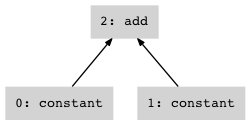

In [2]:
x = constant(2.)
y = constant(2.)
z = x + y
z

`constant(value)` creates an expression whose value is `value`, typically a NumPy array, and `x + y` creates a new expression that is the sum of `x` and `y`, but doesn't actually perform the addition yet. That is the job of `compute_values`, which takes an expression and returns a dictionary mapping from all subexpressions to their values.

In [3]:
values = compute_values(z)
values[z]

4.0

The following operators and NumPy-like operations work on expressions:

* the `[]` operator for indexing or slicing
* `concatenate`, `stack`, `transpose`
* `+`, `-`, `*`, `/` (scalar or elementwise multiplication or division)
* `dot`, `einsum`
* `log`, `exp`
* `maximum`, `minimum`, `clip`
* `where`
* `asum` is like `numpy.sum`; `amax`, `amin`, `mean`

Also, more specialized functions:

* Activation functions `sigmoid`, `tanh`, `hardtanh`, `logsoftmax`, `rectify`
* Loss functions `crossentropy`, `distance2` (squared Euclidean distance)
* Module `conv` provides `convolve` and `pool`, `max_pool`, `mean_pool`

## Parameters ##

As a slightly more complex example, suppose we want to define the following network: $$
\begin{aligned}
h &= \tanh (V i + a) \\
o &= \tanh (W h + b) \\
e &= \|o - c\|^2
\end{aligned}
$$
where $i$ is the input vector and $c$ is the correct output vector. The parameters of the model are matrices $V$ and $W$ and vectors $a$ and $b$.

Parameters are created like constants, using `parameter(value)`, where `value` is the initial value of the parameter.

In [4]:
nh = 3
V = parameter(numpy.random.uniform(-1., 1., (nh, 2)))
a = parameter(numpy.zeros((nh,)))
W = parameter(numpy.random.uniform(-1., 1., (1, nh)))
b = parameter(numpy.zeros((1,)))

The inputs and correct outputs are going to be "constants" whose value we will change from example to example:

In [5]:
i = constant(numpy.empty((2,)))
c = constant(numpy.empty((1,)))

Finally, define the network. This is nearly a straight copy of the equations above:

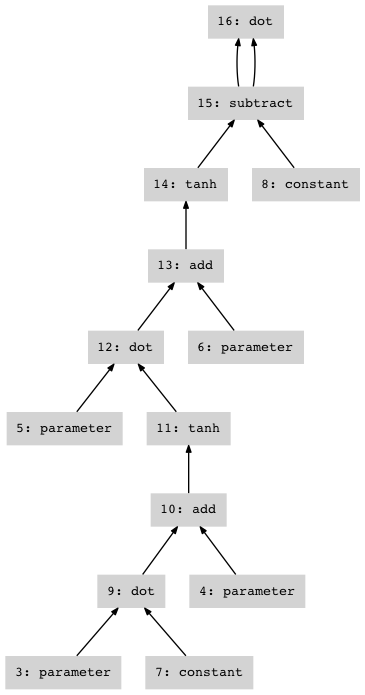

In [6]:
h = tanh(dot(V, i) + a)
o = tanh(dot(W, h) + b)
e = distance2(o, c)
e

## Training ##

To train the network, first create a trainer object (`SGD`/`StochasticGradientDescent`, `Adagrad`, `Adadelta`, `Momentum`, or `Nesterov`). Then, feed it expressions using the `receive` method; the trainer will update the parameters to try to minimize each expression.

In [7]:
import random
trainer = SGD(learning_rate=0.1)
data = [[-1., -1., -1.], 
        [-1.,  1.,  1.],
        [ 1., -1.,  1.],
        [ 1.,  1., -1.]] * 10
for epoch in xrange(10):
    random.shuffle(data)
    loss = 0.
    for x, y, z in data:
        i.value[...] = [x, y]
        c.value[...] = [z]
        loss += trainer.receive(e)
    print(loss/len(data))

1.26393291958
0.891314734712
0.188155285283
0.0469943263666
0.024600482034
0.017526493249
0.0127224090239
0.010137842767
0.00837241824957
0.00708963491692


To save the model, call `save_model(file)` where `file` is a file-like object. To load a model, you must build your expressions in _exactly the same way_ that you did up to the point that you saved the model, then call `load_model(file)`.

## Debugging ##

While it is often the case that a network works perfectly on the first try, bugs do happen. Module `logging` has two flags that you can set to help with debugging:

- `logging.debug` adds information to expression objects so that if an error occurs when using an expression, you get, in addition to the usual traceback, a traceback of where the expression was created.
- `logging.trace` causes `compute_values` and `compute_gradients` to print out their computations step by step.

If you add your own expression operations, you can debug the automatic differentiation using `check_gradients`:

In [8]:
auto = compute_gradients(e)
check = check_gradients(e)
sum(numpy.linalg.norm(auto[x]-check[x])**2 for x in check)

8.727630614846172e-14

## More complex expressions ##

Since expressions are just objects, you can put them inside lists, dicts, etc., and you can also pass them to and return them from functions. By taking advantage of this, you can define very complex networks without very much clutter.

For example, the function `make_layer` simplifies definitions of feedforward neural networks. It takes an input size and output size and returns a function. This function, in turn, creates a fully-connected layer $y = f(Wx+b)$, including properly-initialized parameters $W$ and $b$. The same example above using `make_layer` would be:

In [9]:
h = make_layer(2, nh)(i)
o = make_layer(nh, 1)(h)
e = distance2(o, c)

The parameters of the two layers are there, but hidden from our view. The reason for the two-step usage is to control parameter sharing. If you call `make_layer` twice, you get two different layers with different parameters. But if you call it once and use the result twice, you get two layers with shared parameters.

A possible definition of `make_layer` would be:

In [10]:
def my_make_layer(ni, no):
    W = parameter(numpy.random.uniform(-1., 1., (no, ni)))
    b = parameter(numpy.zeros((no,)))
    def layer(i):
        return tanh(dot(W, i) + b)
    return layer

`my_make_layer` creates a function closure that contains both the inner function and the parameters `W` and `b`. Or if you don't like function closures, we can do the exact same thing using objects:

In [11]:
class my_make_layer(object):
    def __init__(self, ni, no):
        self.W = parameter(numpy.random.uniform(-1., 1., (no, ni)))
        self.b = parameter(numpy.zeros((no,)))
    def __call__(self, i):
        return tanh(dot(self.W, i) + self.b)

The real `make_layer` has some extra bells and whistles.

- it can take a sequence of input sizes instead of a single input size
- a negative input size gives you an input that takes an integer `i` and selects the `i`th row of weights
- the `bias` option lets you specify the initial bias; `None` means no bias
- the `f` option lets you set the activation function (default is `tanh`)

## Transducers ##

We can build unfolded recurrent networks using transducers, which are extensions of class `Transducer`. Their inputs and outputs are sequences of expressions or other objects (e.g., words). A transducer contains, not only parameters like layers do, but an expression representing its internal _state_. A transducer should define two methods:

- `start()` resets the transducer's internal state to the initial state.
- `step(inp)` reads in `inp` as an input and returns the output, updating the internal state.

The following convenience method is defined in terms of the above:

- `transduce(inps)` reads in a sequence of inputs and returns a sequence of outputs.

Module `recurrent` defines three RNN classes:

- `Simple(nh, ni, no)` is a simple RNN, with a tanh inside. Argument `nh` is the number of hidden units, `ni` the number of input units, and `no` the number of output units.
- `LSTM(nh, ni, no)` is a long short term memory RNN, as defined in Graves, "Generating Sequences with RNNs." Arguments are the same as `Simple`.
- `Stacked(r1, r2, ...)` stacks the RNNs `r1`, `r2`, etc., into a deep RNN. Formally, this is the same as FST composition: the output sequence of `r1` is the input sequence of `r2`, and so on.

In [12]:
from penne import recurrent
nh = 100
r = recurrent.LSTM(nh, -256, nh)
output_layer = make_layer(nh, 256, f=logsoftmax)
r.start()
w = map(ord, "^the cat sat on the mat$")
loss = constant(0.)
for t in xrange(len(w)-1):
    h = r.step(w[t])
    o = output_layer(h)
    loss -= o[w[t+1]]

Normally, to train the model, you would build a new expression for each string, but for this simple example, just train the model on the same string over and over:

In [13]:
trainer = Adagrad(learning_rate=0.1)
for i in xrange(100):
    trainer.receive(loss)

Obligatory randomly generated strings:

In [14]:
for i in xrange(10):
    c = ord('^')
    r.start()
    values = {}
    w = []
    for t in xrange(40):
        h = r.step(c)
        o = output_layer(h)
        values = compute_values(o, values)
        c = numpy.argmax(numpy.random.multinomial(1, numpy.exp(values[o])))
        if c == ord('$'): break
        w.append(chr(c))
    print ''.join(w)

the cat sat on the mat
the cat sat on the mat
the cat sat on the mat
the cat sat on the mat
the cat sat on the mat
the cat sat on the mat
the cat sat on the mat
the cat sat on the mat
the cat sat on the mat
the cat sat on the mat


The implementation of `LSTM` is not terribly complicated, and illustrates how to implement transducers. The `__init__` method creates all the parameters (indirectly, using `make_layer`). The `start` method sets the initial states (an LSTM has two of them). The `step` method updates the states according to the LSTM definition.

In [15]:
class LSTM(recurrent.Transducer):
    def __init__(self, hidden_dims, input_dims, output_dims):
        dims = [input_dims, hidden_dims, hidden_dims]
        self.input_gate = make_layer(dims, hidden_dims, f=sigmoid)
        self.forget_gate = make_layer(dims, hidden_dims, f=sigmoid)
        self.output_gate = make_layer(dims, hidden_dims, f=sigmoid)
        self.input_layer = make_layer(dims[:-1], hidden_dims, f=tanh)
        self.h0 = constant(numpy.zeros((hidden_dims,)))
        self.c0 = constant(numpy.zeros((hidden_dims,)))

    def start(self):
        self.h = self.h0
        self.c = self.c0

    def step(self, inp):
        i = self.input_gate(inp, self.h, self.c)
        f = self.forget_gate(inp, self.h, self.c)
        self.c = f * self.c + i * self.input_layer(inp, self.h)
        o = self.output_gate(inp, self.h, self.c)
        self.h = o * tanh(self.c)
        return o